# DNN, BDT and RF in TopFC analysis
Author: Meisam Ghasemi Bostanabad

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [213]:
import uproot
import numpy as np
import pandas as pd
import h5py
import awkward as ak
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_charm':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_charm.root'
    }

'''
filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_up':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_up.root'}
    }
'''

upfile = {}
params = {}
df = {}

# choose which vars to use (multi dimensional)
#VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass', 'weight'] # choose which vars to use (2d)
VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass'] # choose which vars to use (2d)

# define trees and branches to make DataFrame
for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 

## Data exploration

In [214]:
# reduce signal DF size to have resonable Sig/Bkg ratio
df['signal_charm'] = df['signal_charm'][:2000]

In [215]:
print(set(df['ttbar']['isSignal']))
print(set(df['ttbar']['jetNo']))
#print(set(df['ttbar']['weight']))
#print(set(df['signal_charm']['weight']))

{0.0}
{2, 3, 4, 5, 6}


In [216]:
# number of entries in the backgrounds and signals
tot_bkg = 0
for treename in filename.keys():
    if not 'signal' in treename: tot_bkg += df[treename].shape[0]
    print(treename, ":", df[treename].shape)

print("signal/tot bkg:", round((df['signal_charm'].shape[0]/ tot_bkg),1))
#print("Null entries:", df['signal_charm'].isna().sum())

ttbar : (381, 7)
WZ : (936, 7)
ZZ : (76, 7)
signal_charm : (2000, 7)
signal/tot bkg: 1.4


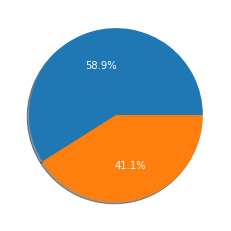

In [217]:
counts_signal = df['signal_charm'].shape[0]
counts_background = tot_bkg
plt.pie([counts_signal, counts_background], shadow=True, labels=['Signal ','Background'], textprops={'color':"w"}, autopct='%1.1f%%');

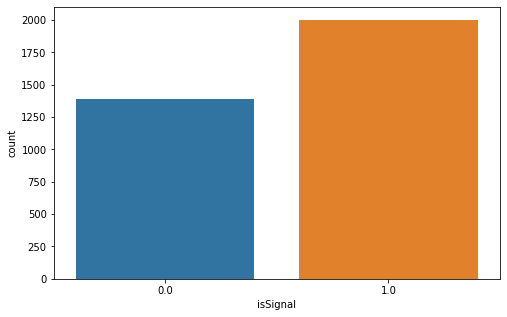

In [218]:
# show the number of total signals and backgrounds
df_all = pd.concat([df[treename] for treename in filename.keys()])
plt.figure(figsize=(8,5))
sns.countplot(x='isSignal',data=df_all);

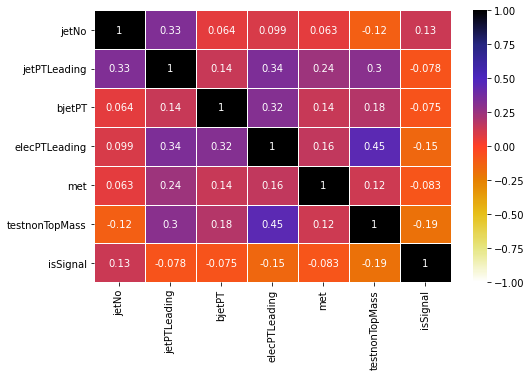

In [219]:
# show the correlation between features
plt.figure(figsize=(8,5))
#sns.heatmap(df_all.corr(), annot=True, linewidth=.5)
sns.heatmap(df_all.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r);

In [220]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jetNo           3393 non-null   int32  
 1   jetPTLeading    3393 non-null   float64
 2   bjetPT          3393 non-null   float64
 3   elecPTLeading   3393 non-null   float64
 4   met             3393 non-null   float64
 5   testnonTopMass  3393 non-null   float64
 6   isSignal        3393 non-null   float64
dtypes: float64(6), int32(1)
memory usage: 263.3 KB


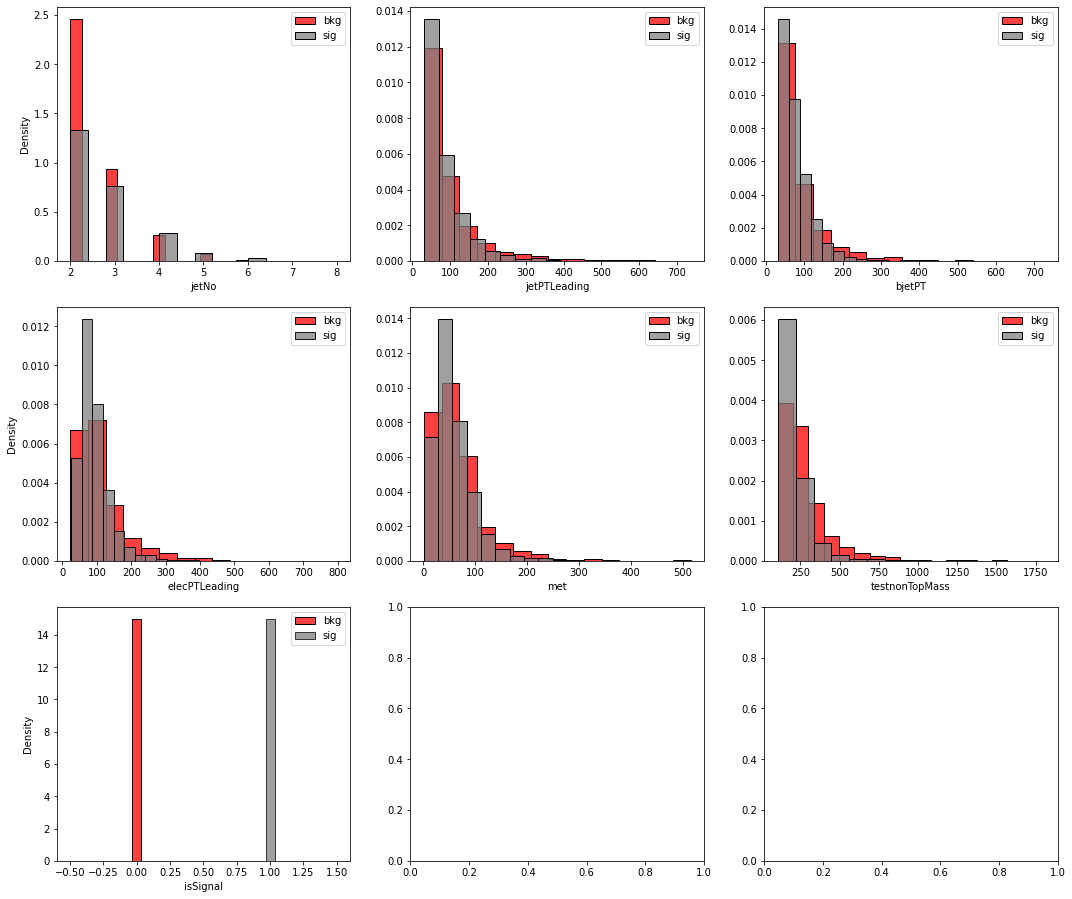

In [221]:
# Function to plot distributions of the float features
import math 
def hist(df1, df2, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        #sns.histplot(data = df, x = cols[i], bins = bins, hue = 'isSignal', palette = ['grey', 'red'], ax = ax[i // ncols, i % ncols], stat="probability")
        sns.histplot(data = df1, x = cols[i], bins = bins, color = 'red',
                      ax = ax[i // ncols, i % ncols], stat="density", label='bkg')
        sns.histplot(data = df2, x = cols[i], bins = bins, color = 'grey',
                      ax = ax[i // ncols, i % ncols], stat="density", label='sig')       
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        ax[i // ncols, i % ncols].legend()
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
        
    plt.tight_layout()
    plt.show()

# Distributions of the float features
hist(df_all[df_all['isSignal']==0].replace(-999, np.nan),
     df_all[df_all['isSignal']==1].replace(-999, np.nan),
     #list(df_all.columns[df_all.dtypes == 'float64']),
     list(df_all.columns),
     bins = math.floor(len(df_all)**(1/3)),
     ncols = 3)

## Define the models

## NN from Tensorflow
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [222]:
df_all = pd.concat([df[treename] for treename in filename.keys()])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# baseline keras model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input') 
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('TopFC_dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6)]               0         
                                                                 
 output (Dense)              (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


## Run training 
Here, we run the training.

In [223]:
# Train classifier
import time
start = time.time() # time at start of whole processing

history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=512, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Epoch 1/1000
6/6 [==============================] - 1s 30ms/step - loss: 0.6958 - accuracy: 0.4775 - val_loss: 0.6902 - val_accuracy: 0.5052
Epoch 2/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5092 - val_loss: 0.6872 - val_accuracy: 0.5479
Epoch 3/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.5475 - val_loss: 0.6844 - val_accuracy: 0.5950
Epoch 4/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.6885 - accuracy: 0.5792 - val_loss: 0.6817 - val_accuracy: 0.6156
Epoch 5/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.6862 - accuracy: 0.5976 - val_loss: 0.6790 - val_accuracy: 0.6392
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6842 - accuracy: 0.6109 - val_loss: 0.6765 - val_accuracy: 0.6510
Epoch 7/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6821 - accuracy: 0.6209 - val_loss: 0.6741 - val_accuracy: 0.6583
Epoch 8/1000
6/6 [=

## Plot performance and reports
Here, we plot the history of the training and the performance in a ROC curve

85/85 [==============================] - 0s 4ms/step


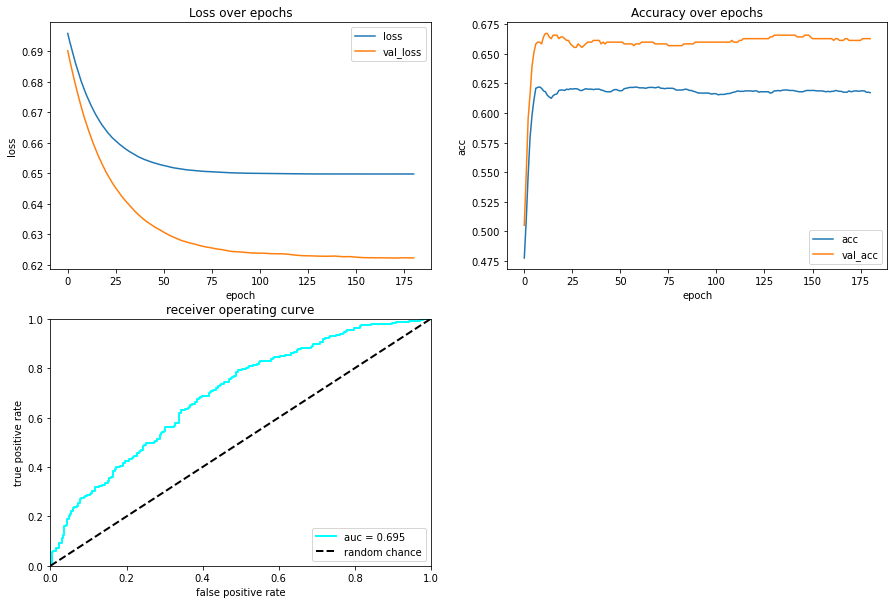

107/107 [==============================] - 0s 737us/step
0.6627393225331369
0.6171702284450995
Classification report for the test set
              precision    recall  f1-score   support

  background       0.69      0.28      0.40       272
      signal       0.66      0.92      0.77       407

    accuracy                           0.66       679
   macro avg       0.68      0.60      0.58       679
weighted avg       0.67      0.66      0.62       679

Classification report for the total set
              precision    recall  f1-score   support

  background       0.61      0.25      0.35      1393
      signal       0.63      0.89      0.74      2000

    accuracy                           0.63      3393
   macro avg       0.62      0.57      0.54      3393
weighted avg       0.62      0.63      0.58      3393

107/107 [==============================] - 0s 2ms/step


In [224]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score

%matplotlib inline
def loss_accuracy_plotter(history):
    # plot loss vs epoch
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.legend(loc="upper right")
    ax.set_title('Loss over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # plot accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    ax.plot(history.history['accuracy'], label='acc')
    ax.plot(history.history['val_accuracy'], label='val_acc')
    ax.legend(loc="lower right")
    ax.set_title('Accuracy over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Plot ROC
    Y_predict = model.predict(X_test)
    Y_predict_train = model.predict(X_train_val)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('receiver operating curve')
    ax.legend(loc="lower right")
    plt.show()

loss_accuracy_plotter(history)


from sklearn.metrics import accuracy_score, classification_report

Y_pred_test = model.predict(X_test)
Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0])
Y_pred_train = model.predict(X_train_val)
Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])
Y_pred_tot = model.predict(scaler.transform(X)).round()
Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])

# accuracy score
print(accuracy_score(Y_test.round(), Y_pred_test.round()))
print(accuracy_score(Y_train_val.round(), Y_pred_train.round()))

# classification report for the test and total sets
print("Classification report for the test set")
print(classification_report(Y_test.round(), Y_pred_test.round(), target_names=['background', 'signal']))
print("Classification report for the total set")
print(classification_report(Y.round(), Y_pred_tot.round(), target_names=['background', 'signal']))

fpr_nn, tpr_nn, thresholds_nn = roc_curve(Y_test, Y_pred_test) # get FPRs, TPRs and thresholds for neural network

df_all['dense_NN'] = model.predict(scaler.transform(X)).round() # add prediction to array
#df_all['dense_NN'] = model.predict_proba(X)[:, 1]
#print (df_all.iloc[:5])

## NN from Sklearn


In [225]:
from sklearn.neural_network import MLPClassifier

import time
start = time.time() # time at start of whole processing

hidden_layer_sizes = [len(VARS)] # 1 hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), # define parameters for our multi-layer-perceptron
                    max_iter=500 ) # max number of iterations
mlp.fit(X_train_val,Y_train_val)

y_predict = mlp.predict_proba(X_test)[:,1].round()
print("Classification report for the test set")
print(classification_report(Y_test.round(), y_predict.round(), target_names=['background', 'signal']))

ytot_predict = mlp.predict_proba(X)[:,1].round()
print("Classification report for the total set")
print(classification_report(Y.round(), ytot_predict.round(), target_names=['background', 'signal']))

fpr_nn_sk, tpr_nn_sk, thresholds_nn_sk = roc_curve(Y_test.round(), y_predict.round()) # get FPRs, TPRs and thresholds for neural network


#df_all['sklearn_dense_NN'] = mlp.predict(X) # add prediction to array
df_all['sklearn_dense_NN'] = mlp.predict(scaler.transform(X)).round() # add prediction to array

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Classification report for the test set
              precision    recall  f1-score   support

  background       0.68      0.37      0.48       272
      signal       0.68      0.88      0.77       407

    accuracy                           0.68       679
   macro avg       0.68      0.63      0.62       679
weighted avg       0.68      0.68      0.65       679

Classification report for the total set
              precision    recall  f1-score   support

  background       0.41      1.00      0.58      1393
      signal       0.00      0.00      0.00      2000

    accuracy                           0.41      3393
   macro avg       0.21      0.50      0.29      3393
weighted avg       0.17      0.41      0.24      3393

Time taken: 1.8s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

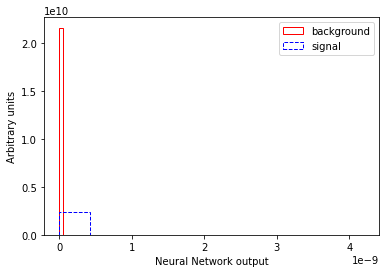

In [226]:
# we first plot the Neural Network output
signal_decisions = mlp.predict_proba(X[Y>0.5])[:, 1] # get probabilities on signal
background_decisions = mlp.predict_proba(X[Y<0.5])[:, 1] # get probabilities on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('Neural Network output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend

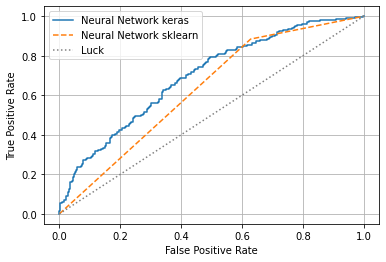

In [227]:
plt.plot(fpr_nn, tpr_nn, label='Neural Network keras') # plot random forest ROC
plt.plot(fpr_nn_sk, tpr_nn_sk, linestyle='dashed', label='Neural Network sklearn') # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

## Save the predictions

In [228]:
df_all[df_all['isSignal']==1].head()
df_all[df_all['dense_NN']==1].head()
df_all[df_all['sklearn_dense_NN']==1].head()

,jetNo,jetPTLeading,bjetPT,elecPTLeading,met,testnonTopMass,isSignal,dense_NN,sklearn_dense_NN
entry,,,,,,,,,
1,3,67.292442,32.879086,87.680885,32.989780,206.483257,0.0,1.0,1.0
2,5,216.352081,48.157005,33.488476,145.810104,176.785610,0.0,1.0,1.0
3,4,347.645050,71.226440,65.760910,186.715225,172.066595,0.0,1.0,1.0
4,3,64.248962,80.717056,36.373375,61.273373,159.428297,0.0,1.0,1.0
5,4,53.700779,94.250420,65.454498,81.860435,170.679508,0.0,1.0,1.0


# Recurrent Neural Network (LSTM)

In [229]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate,GRU,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import FixedLenFeature
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, normalize

import tensorflow as tf


X_train_LSTM = np.reshape(X_train_val, (X_train_val.shape[0],X_train_val.shape[1],1))    #(225000, 30, 1)
X_test_LSTM = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))        #(25000, 30, 1)

def build_Lstm_model(train_x,train_y,test_x,test_y):
    inp = Input(shape=(train_x.shape[1],train_x.shape[2]))
    rnn_1st_model = LSTM(units=60, return_sequences=True,recurrent_dropout=0.1)(inp)
    rnn_2nd_model = LSTM(units=60,recurrent_dropout=0.1)(rnn_1st_model)
    dense_layer = Dense(128)(rnn_2nd_model)
    drop_out = Dropout(0.2)(dense_layer)
    output = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(drop_out)
    model = Model(inp, output)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_LSTM.h5', monitor='val_loss', save_best_only=True)]
    model.summary()
    model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),
                        tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")
    history = model.fit(train_x, train_y, 
          epochs = 20, 
          batch_size = 128, 
          validation_data=(test_x,  test_y), 
          callbacks=callbacks)
    return history,model
history_LSTM,Lstm_model = build_Lstm_model(X_train_LSTM,Y_train_val,X_test_LSTM,Y_test)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 6, 60)             14880     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 128)               7808      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 class (Dense)               (None, 1)                 129       
                                                                 
Total params: 51,857
Trainable params: 51,857
Non-trainabl

KeyError: 'accuracy'

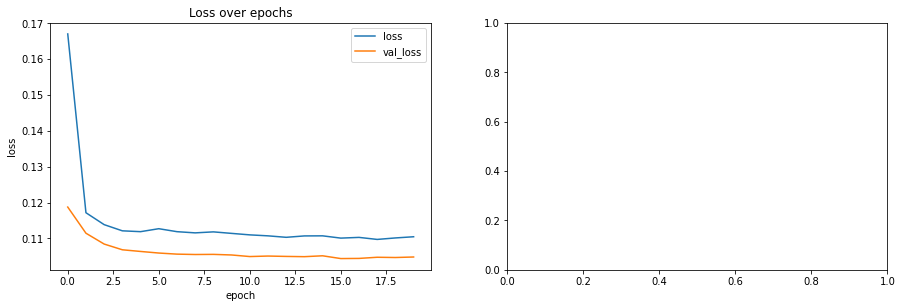

In [230]:
loss_accuracy_plotter(history_LSTM)

# Boosted Decision Tree

In [231]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train_val, Y_train_val)
y_pred_BDT = dtree.predict(X_test)

print("Classification report for the test set")
print(accuracy_score(Y_test,y_pred_BDT))
print("Classification report for the total set")
print(classification_report(Y_test.round(), y_pred_BDT.round(), target_names=['background', 'signal']))
#print(classification_report(Y_test,y_pred_BDT))

#df_all['dense_BDT'] = dtree.predict(X) # add prediction to array
df_all['dense_BDT_old'] = dtree.predict(scaler.transform(X)) # add prediction to array
#df_all[df_all['isSignal']==1].head()

Classification report for the test set
0.5758468335787923
Classification report for the total set
              precision    recall  f1-score   support

  background       0.47      0.48      0.47       272
      signal       0.65      0.64      0.64       407

    accuracy                           0.58       679
   macro avg       0.56      0.56      0.56       679
weighted avg       0.58      0.58      0.58       679



In [232]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=2) # maximum depth of the tree
bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME', # SAMME discrete boosting algorithm
                        n_estimators=12, # max number of estimators at which boosting is terminated
                        learning_rate=0.5) # shrinks the contribution of each classifier by learning_rate

start = time.time() # time at start of BDT fit
bdt.fit(X_train_val, Y_train_val) # fit BDT to training set
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(bdt)

y_pred_BDT = bdt.predict(X_test)
print(accuracy_score(Y_test,y_pred_BDT))
print("Classification report for the test set")
print(classification_report(Y_test, y_pred_BDT, target_names=['background', 'signal']))

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(Y_test, y_pred_BDT)

df_all['dense_BDT'] = bdt.predict(scaler.transform(X)) # add prediction to array

Time taken to fit BDT: 0.1s
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=12)
0.6642120765832106
Classification report for the test set
              precision    recall  f1-score   support

  background       0.61      0.45      0.52       272
      signal       0.69      0.81      0.74       407

    accuracy                           0.66       679
   macro avg       0.65      0.63      0.63       679
weighted avg       0.66      0.66      0.65       679



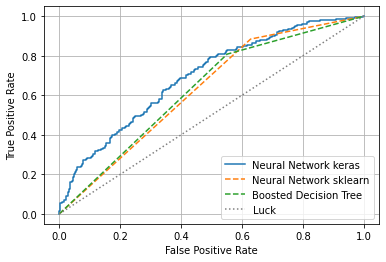

In [234]:
plt.plot(fpr_nn, tpr_nn, label='Neural Network keras') # plot random forest ROC
plt.plot(fpr_nn_sk, tpr_nn_sk, linestyle='dashed', label='Neural Network sklearn') # plot neural network ROC
plt.plot(fpr_bdt, tpr_bdt, linestyle='dashed', label='Boosted Decision Tree') # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

# Random Forest

In [236]:
# 8. Random Forest classifier for prediction and evaluate the model

from sklearn.ensemble import RandomForestClassifier

# the parameters for initializing are called hyperprameters
RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=420) # initialise your random forest classifier
RF_clf.fit(X_train_val, Y_train_val) # fit to the training data
y_pred_RF = RF_clf.predict(X_test) # make predictions on the test data

# for my own curiosity
y_pred_RF_train = RF_clf.predict(X_train_val)
#Y_pred = RF_clf.predict(X)

# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print(accuracy_score(Y_test, y_pred_RF))
print(accuracy_score(Y_train_val, y_pred_RF_train))

print(classification_report(Y_test.round(), y_pred_RF.round(), target_names=['background', 'signal']))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_RF)

df_all['dense_RF'] = RF_clf.predict(scaler.transform(X)) # add prediction to array

0.6759941089837997
0.8021370670596905
              precision    recall  f1-score   support

  background       0.67      0.38      0.49       272
      signal       0.68      0.87      0.76       407

    accuracy                           0.68       679
   macro avg       0.67      0.63      0.62       679
weighted avg       0.67      0.68      0.65       679



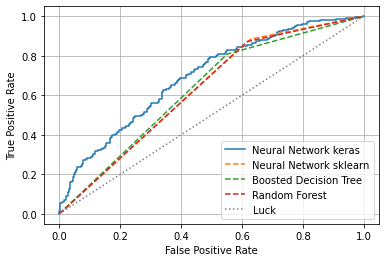

In [237]:
plt.plot(fpr_nn, tpr_nn, label='Neural Network keras') # plot random forest ROC
plt.plot(fpr_nn_sk, tpr_nn_sk, linestyle='dashed', label='Neural Network sklearn') # plot neural network ROC
plt.plot(fpr_bdt, tpr_bdt, linestyle='dashed', label='Boosted Decision Tree') # plot BDT ROC
plt.plot(fpr_rf, tpr_rf, linestyle='dashed', label='Random Forest') # plot RF ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

In [238]:
df_all.head()

,jetNo,jetPTLeading,bjetPT,elecPTLeading,met,testnonTopMass,isSignal,dense_NN,sklearn_dense_NN,dense_BDT_old,dense_BDT,dense_RF
entry,,,,,,,,,,,,
0,2,181.824814,163.677521,88.220581,63.312572,475.149068,0.0,0.0,0.0,0.0,0.0,0.0
1,3,67.292442,32.879086,87.680885,32.989780,206.483257,0.0,1.0,1.0,0.0,1.0,1.0
2,5,216.352081,48.157005,33.488476,145.810104,176.785610,0.0,1.0,1.0,1.0,1.0,1.0
3,4,347.645050,71.226440,65.760910,186.715225,172.066595,0.0,1.0,1.0,0.0,1.0,0.0
4,3,64.248962,80.717056,36.373375,61.273373,159.428297,0.0,1.0,1.0,0.0,1.0,1.0


# Plot NN output vs input variables
Here, we will plot the NN output and devision boundary as a function of the input variables.

**Question 1:** How can we fill the correct numpy arrays for plotting?

In [7]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        #myZI[i,j] = ??? # change this

myZI = model.predict(np.c_[myXI.ravel(), myYI.ravel()])
myZI = myZI.reshape(myXI.shape)

(200, 200)


**Question 2:** The code below shows how to plot the NN output. How can we plot the NN decision boundary?

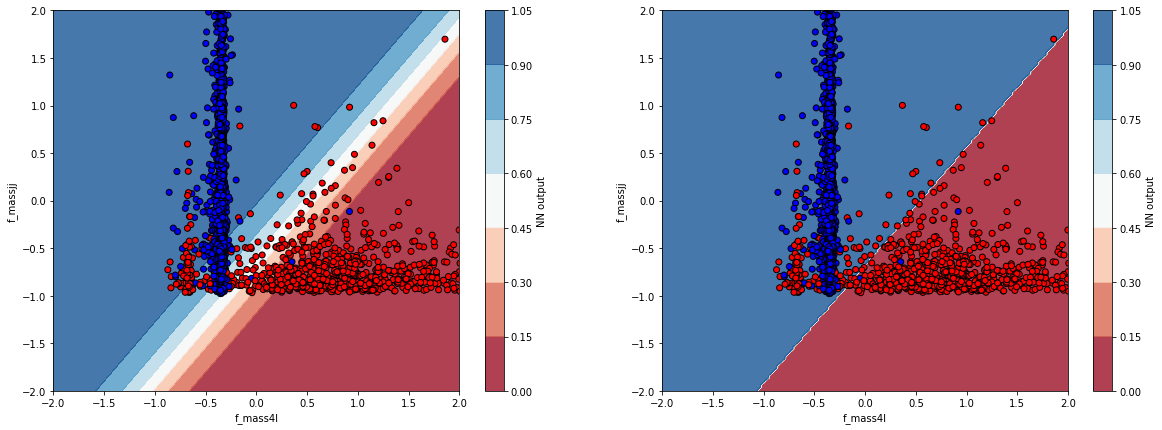

In [8]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points
ax = plt.subplot(1, 2, 2)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

**Question 3:** What happens if you increase/decrease the number of hidden layers?

**Question 4:** What happens if you increase/decrease the number of nodes per hidden layer?

**Question 5:** What happens if you add/remove dropout?

**Question 6:** What happens if you add/remove early stopping?

## Add prediction to `ROOT` trees
Here we'll add the precition we've computed to `ROOT` trees.

In [9]:
from root_numpy import root2array, array2root


def get_features_from_file(filename='', treename='', branches=[]):
    t = root2array(filename, treename=treename, branches=branches) # structured numpy array 
    #print t.shape 
    t = t.view(np.float32).reshape(t.shape + (-1,)) # normal numpy array (trick from https://stackoverflow.com/questions/5957380/convert-structured-array-to-regular-numpy-array)
    #print t.shape
    return t

def write_prediction_to_file(features, model, filename='',treename='',branch=''):
    y_predict_all = model.predict(features) # normal numpy array
    #print y_predict_all.shape
    y_predict_all = np.array(y_predict_all, dtype=[(branch, np.float32)]) # structured numpy array
    #print y_predict_all.shape
    array2root(y_predict_all, filename, treename=treename, mode='recreate')
    
X_all = get_features_from_file('data/ntuple_4mu_VV.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_VV_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

X_all = get_features_from_file('data/ntuple_4mu_bkg.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_bkg_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

Welcome to JupyROOT 6.14/04
